In [11]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import scipy
import seaborn as sns

NBINS = 20
ALPHA = .05
CLIP_LOWER = .01
CLIP_UPPER = .99

In [18]:
def average_values(df, cols, val_name):
    d = df.groupby(cols)[val_name].mean().reset_index(name='mean_val')
    assert len(d) == len(df[cols].drop_duplicates())
    return d

def create_matrix(df, n_rows, n_cols, row_name, col_name, val_name):
    avg_df = average_values(df, [row_name, col_name], val_name)
    arr = np.zeros((n_rows, n_cols))
    row = avg_df[row_name].to_numpy()
    col = avg_df[col_name].to_numpy()
    val = avg_df['mean_val'].to_numpy()
    arr[row, col] = val
    return arr

def get_singular_values(M):
    U, S, Vh = np.linalg.svd(M, full_matrices=True)
    return S

def plot_singular_values(write_fn, df, val_name):
    plt.clf()
    n_samples = df.sample_id.nunique()
    n_drugs = df.drug_id.nunique()
    arr = create_matrix(df, n_samples, n_drugs, 'sample_id', 'drug_id', val_name)
    S = get_singular_values(arr)
    plt.ylabel('singular value')
    plt.xlabel('ordered rank')
    title = val_name + ' singular values'
    plt.title(title)
    plt.scatter(range(len(S)), S)
    plt.savefig(write_fn, bbox_inches='tight')
    
def create_heatmap(write_fn, df, val_name):
    plt.clf()
    n_samples = df.sample_id.nunique()
    n_drugs = df.drug_id.nunique()
    arr = create_matrix(df, n_samples, n_drugs, 'sample_id', 'drug_id', val_name)
    sns.heatmap(arr)
    plt.title(val_name)
    plt.ylabel('sample_id')
    plt.xlabel('drug_id')
    plt.savefig(write_fn, bbox_inches='tight')
    plt.show()

def normality_test(x, name):
    k2, p = scipy.stats.normaltest(x)
    s = name + ', p = ' + str(round(p, 6)) + ' --> '
    if p < ALPHA:  # null hypothesis: x comes from a normal distribution
        s += 'p < ' + str(ALPHA) + '\n'
        s += 'The null hypothesis (that data come from normal dist) CAN be rejected.'
    else:
        s += 'p >= ' + str(ALPHA) + '\n'
        s += 'The null hypothesis (that data come from normal dist) CANNOT be rejected.'
    return s

def mean_centered(df, value):
    f = df[['sample_id', 'drug_id', value]]
    g = f.merge(f.groupby(['sample_id', 'drug_id'])[value].mean().reset_index(name='mean'),
               on=['sample_id', 'drug_id'],
               validate='many_to_one')
    g['centered'] = g[value] - g['mean']
    return g['centered'].to_numpy()

def plot_mean_centered(df, value, name):
    x = mean_centered(df, value)
    x_axis = np.arange(np.min(x), np.max(x), 0.001)
    sns.histplot(x, stat='density', bins=NBINS)
    plt.plot(x_axis, scipy.stats.norm.pdf(x_axis, loc=np.mean(x), scale=np.std(x)), color='r')
    title = name + '\n' + 'std: ' + str(round(np.std(x), 2))
    plt.title(title)
    return normality_test(x, name)

def normality_plots(write_fn, df, value_type):
    plt.clf()
    fig = plt.figure()
    suptitle = value_type + ' , mean-centered'
    plt.suptitle(suptitle)
    plt.subplot(1, 3, 1)
    s_rep = plot_mean_centered(df, 'REP' + value_type, 'REP')
    plt.subplot(1, 3, 2)
    s_gdsc = plot_mean_centered(df, 'GDSC' + value_type, 'GDSC')
    plt.subplot(1, 3, 3)
    s_ctd2 = plot_mean_centered(df, 'CTD2' + value_type, 'CTD2')
    fig.tight_layout()
    plt.savefig(write_fn, bbox_inches='tight')

In [13]:
df = pd.read_csv('~/Documents/research/tansey/msk_intern/pyro_model/data/rep-gdsc-ctd2-overlap.csv')
df.head()

,Drug.Name,ccle,REP_auc_overlap,CTD2_auc_overlap,GDSC_auc_overlap,drug_id,sample_id
0,MASITINIB,MFE296,1.0,0.972505,0.998475,0,0
1,MASITINIB,PSN1,1.0,0.999926,0.999475,0,1
2,MASITINIB,KYSE150,1.0,0.999783,0.987924,0,2
3,MASITINIB,ESS1,1.0,0.993567,0.963070,0,3
4,MASITINIB,A172,1.0,0.999033,0.999867,0,4


In [4]:
# take log of auc's
df['REP_log_auc_overlap'] = np.log2(df['REP_auc_overlap'])
df['GDSC_log_auc_overlap'] = np.log2(df['GDSC_auc_overlap'])
df['CTD2_log_auc_overlap'] = np.log2(df['CTD2_auc_overlap'])
# clip and take logit of auc's
df['clip_REP_auc_overlap'] = df['REP_auc_overlap'].clip(lower=CLIP_LOWER, upper=CLIP_UPPER)
df['clip_GDSC_auc_overlap'] = df['GDSC_auc_overlap'].clip(lower=CLIP_LOWER, upper=CLIP_UPPER)
df['clip_CTD2_auc_overlap'] = df['CTD2_auc_overlap'].clip(lower=CLIP_LOWER, upper=CLIP_UPPER)
df['REP_logit_auc_overlap'] = scipy.special.logit(df['clip_REP_auc_overlap'])
df['GDSC_logit_auc_overlap'] = scipy.special.logit(df['clip_GDSC_auc_overlap'])
df['CTD2_logit_auc_overlap'] = scipy.special.logit(df['clip_CTD2_auc_overlap'])

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

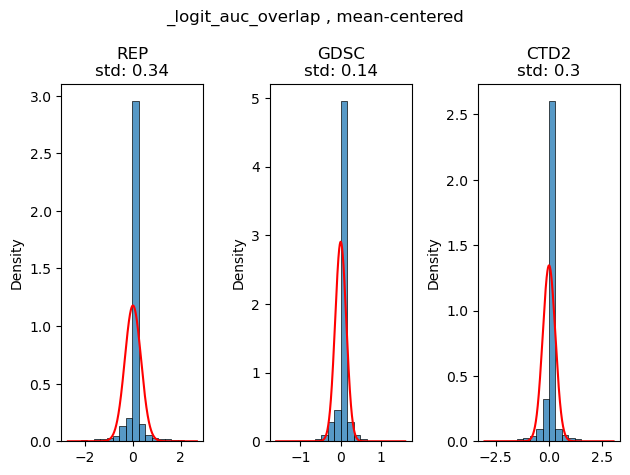

In [5]:
save_dir = '../results/2023-07-18/auc_overlap'
normality_plots(save_dir + '/auc_overlap.png', df, '_auc_overlap')
normality_plots(save_dir + '/log_auc_overlap.png', df, '_log_auc_overlap')
normality_plots(save_dir + '/logit_auc_overlap.png', df, '_logit_auc_overlap')

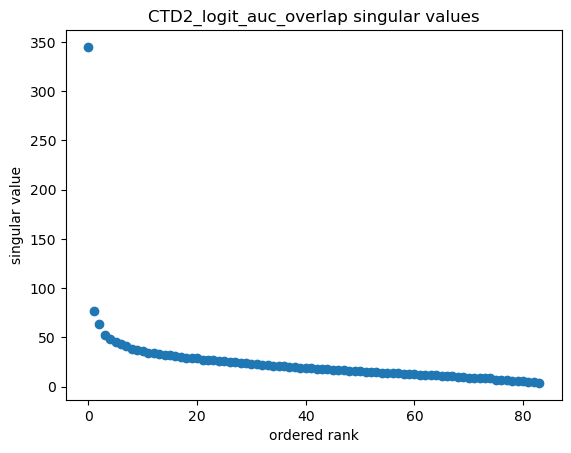

In [6]:
# raw overlaps
plot_singular_values(save_dir + '/REP_auc_sv.png', df, 'REP_auc_overlap')
plot_singular_values(save_dir + '/GDSC_auc_sv.png', df, 'GDSC_auc_overlap')
plot_singular_values(save_dir + '/CTD2_auc_sv.png', df, 'CTD2_auc_overlap')
# log overlaps
plot_singular_values(save_dir + '/REP_log_auc_sv.png', df, 'REP_log_auc_overlap')
plot_singular_values(save_dir + '/GDSC_log_auc_sv.png', df, 'GDSC_log_auc_overlap')
plot_singular_values(save_dir + '/CTD2_log_auc_sv.png', df, 'CTD2_log_auc_overlap')
# logit overlaps
plot_singular_values(save_dir + '/REP_logit_auc_sv.png', df, 'REP_logit_auc_overlap')
plot_singular_values(save_dir + '/GDSC_logit_auc_sv.png', df, 'GDSC_logit_auc_overlap')
plot_singular_values(save_dir + '/CTD2_logit_auc_sv.png', df, 'CTD2_logit_auc_overlap')

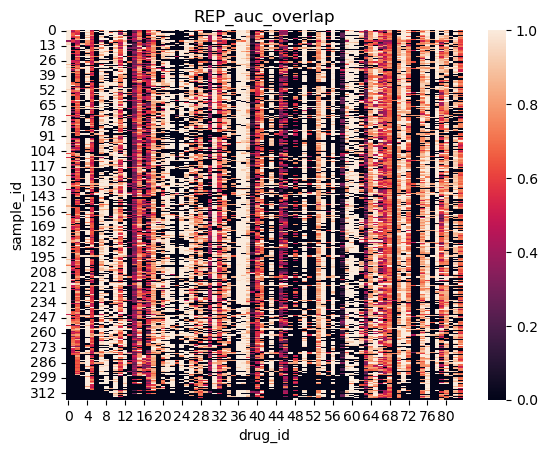

In [20]:
# create heatmaps
save_dir = '../results/2023-07-18/heatmaps'
create_heatmap(save_dir + '/REP_auc_overlap.png', df, 'REP_auc_overlap')

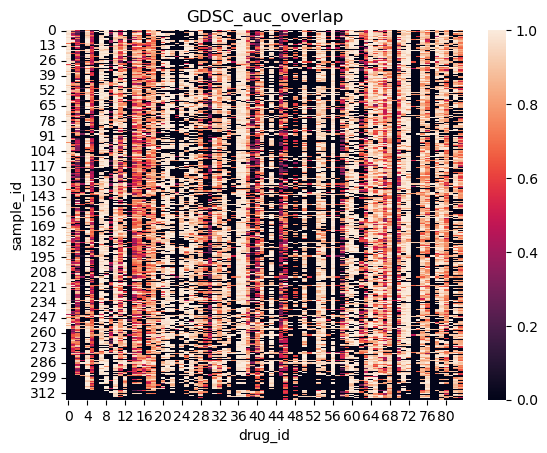

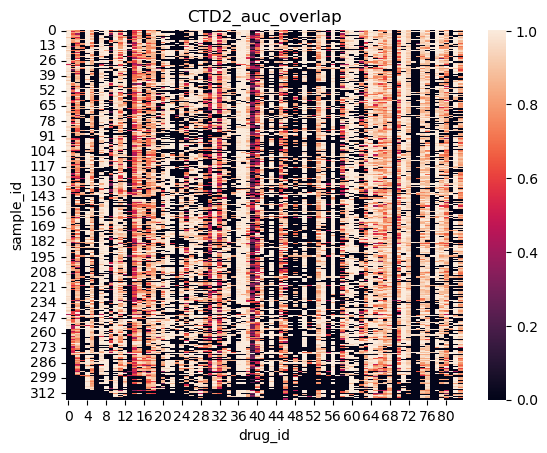

In [21]:
create_heatmap(save_dir + '/GDSC_auc_overlap.png', df, 'GDSC_auc_overlap')
create_heatmap(save_dir + '/CTD2_auc_overlap.png', df, 'CTD2_auc_overlap')

In [7]:
df = pd.read_csv('~/Documents/research/tansey/msk_intern/pyro_model/data/rep-gdsc-ctd2-pub.csv')
df.head()

,Drug.Name,ccle,REP_published_auc,CTD2_published_auc,GDSC_published_auc,drug_id,sample_id
0,MASITINIB,MFE296,1.592769,12.921,0.94,0,0
1,MASITINIB,PSN1,1.684585,14.266,0.88,0,1
2,MASITINIB,KYSE150,1.409029,14.356,0.98,0,2
3,MASITINIB,ESS1,1.448933,13.714,0.86,0,3
4,MASITINIB,A172,1.714048,14.323,0.88,0,4


In [8]:
# take log of auc's
df['REP_log_published_auc'] = np.log2(df['REP_published_auc'])
df['GDSC_log_published_auc'] = np.log2(df['GDSC_published_auc'])
df['CTD2_log_published_auc'] = np.log2(df['CTD2_published_auc'])
# clip and take logit of auc's
df['clip_REP_published_auc'] = df['REP_published_auc'].clip(lower=CLIP_LOWER, upper=CLIP_UPPER)
df['clip_GDSC_published_auc'] = df['GDSC_published_auc'].clip(lower=CLIP_LOWER, upper=CLIP_UPPER)
df['clip_CTD2_published_auc'] = df['CTD2_published_auc'].clip(lower=CLIP_LOWER, upper=CLIP_UPPER)
df['REP_logit_published_auc'] = scipy.special.logit(df['clip_REP_published_auc'])
df['GDSC_logit_published_auc'] = scipy.special.logit(df['clip_GDSC_published_auc'])
df['CTD2_logit_published_auc'] = scipy.special.logit(df['clip_CTD2_published_auc'])

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

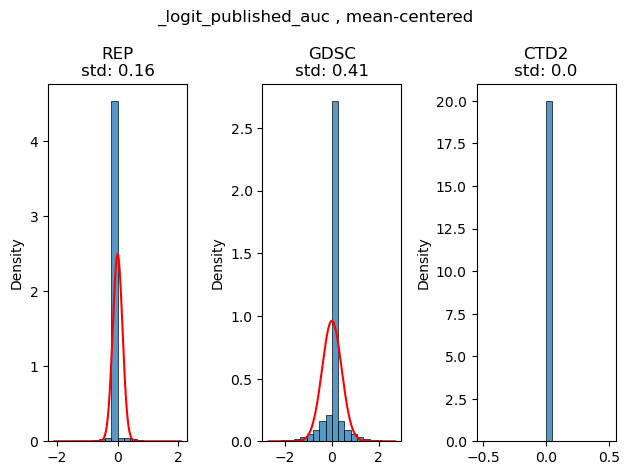

In [9]:
save_dir = '../results/2023-07-18/published_auc'
normality_plots(save_dir + '/auc_pub.png', df, '_published_auc')
normality_plots(save_dir + '/log_auc_pub.png', df, '_log_published_auc')
normality_plots(save_dir + '/logit_auc_pub.png', df, '_logit_published_auc')

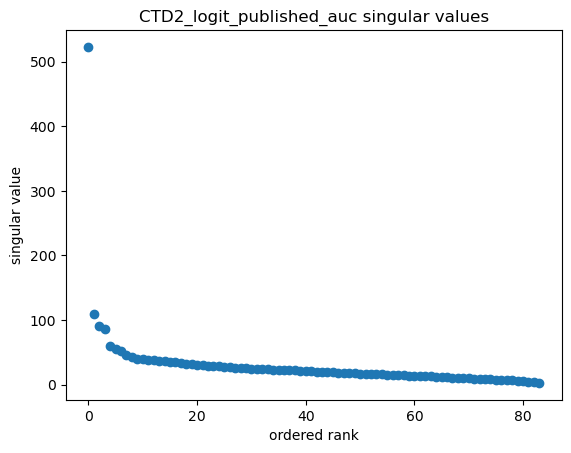

In [10]:
# raw overlaps
plot_singular_values(save_dir + '/REP_pub_auc_sv.png', df, 'REP_published_auc')
plot_singular_values(save_dir + '/GDSC_pub_auc_sv.png', df, 'GDSC_published_auc')
plot_singular_values(save_dir + '/CTD2_pub_auc_sv.png', df, 'CTD2_published_auc')
# log overlaps
plot_singular_values(save_dir + '/REP_log_pub_auc_sv.png', df, 'REP_log_published_auc')
plot_singular_values(save_dir + '/GDSC_log_pub_auc_sv.png', df, 'GDSC_log_published_auc')
plot_singular_values(save_dir + '/CTD2_log_pub_auc_sv.png', df, 'CTD2_log_published_auc')
# logit overlaps
plot_singular_values(save_dir + '/REP_logit_pub_auc_sv.png', df, 'REP_logit_published_auc')
plot_singular_values(save_dir + '/GDSC_logit_pub_auc_sv.png', df, 'GDSC_logit_published_auc')
plot_singular_values(save_dir + '/CTD2_logit_pub_auc_sv.png', df, 'CTD2_logit_published_auc')

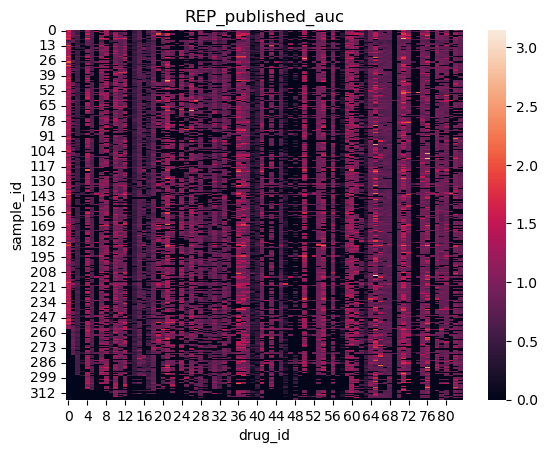

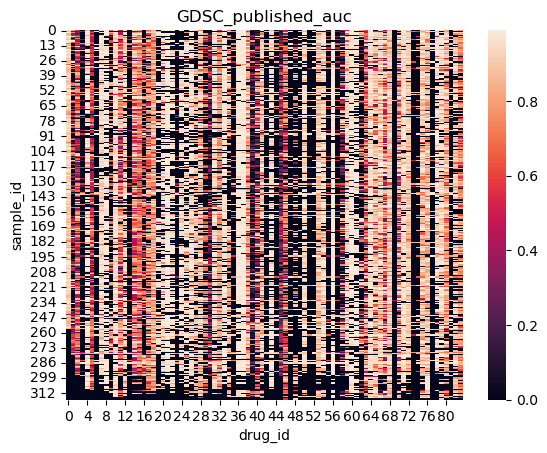

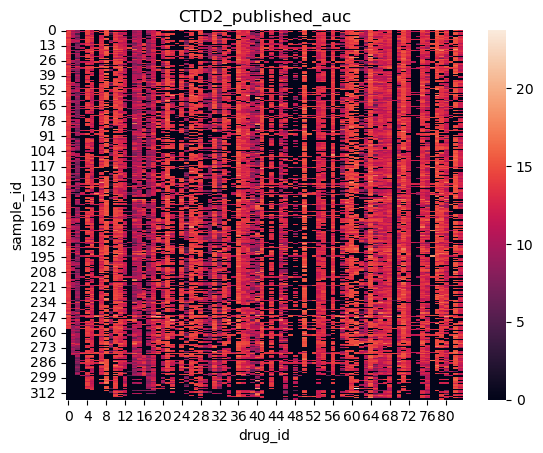

In [22]:
# create heatmaps
df = pd.read_csv('~/Documents/research/tansey/msk_intern/pyro_model/data/rep-gdsc-ctd2-pub.csv')
save_dir = '../results/2023-07-18/heatmaps'
create_heatmap(save_dir + '/REP_pub_auc.png', df, 'REP_published_auc')
create_heatmap(save_dir + '/GDSC_pub_auc.png', df, 'GDSC_published_auc')
create_heatmap(save_dir + '/CTD2_pub_auc.png', df, 'CTD2_published_auc')